Análisis de datos en salud
============================

Unidad 3 - Parte práctica
-----------------------------------------------------



## Datos clínicos de pacientes con enfermedades cardiovasculares

El dataset `cardio_train.csv` es una recopilación de datos médicos y demográficos de pacientes, junto con información sobre si padecen o no una enfermedad cardiovascular. Los datos incluyen características como edad, sexo, el peso y la altura, información sobre presión sistolica y diastólica, nivel de colesterol y glucosa e información sobre sus hábitos.

A continuación podemos información sobre las variables del dataset:

|Characteristic | Type | Column name | Value |
| -------- | ------- | ------- | ------- |
|Age | Objective Feature | age | int (days) |
|Height | Objective Feature | height | int (cm) |
|Weight | Objective Feature | weight | float (kg) |
|Gender | Objective Feature | gender | categorical code |
|Systolic blood pressure | Examination Feature | ap_hi | int |
|Diastolic blood pressure | Examination Feature | ap_lo | int |
|Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
|Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
|Smoking | Subjective Feature | smoke | binary |
|Alcohol intake | Subjective Feature | alco | binary |
|Physical activity | Subjective Feature | active | binary |
|Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from imblearn import *
from sklearn import metrics

# Montamos la unidad Drive para acceder a los archivos de Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Especificamos la ruta hasta la carpeta donde tenemos los archivos
%cd /content/drive/MyDrive/Data Health/Parte práctica-3/cardio_train.csv

Mounted at /content/drive
[Errno 20] Not a directory: '/content/drive/MyDrive/Data Health/Parte práctica-3/cardio_train.csv'
/content


### Ejercicio 1

a) Primero de todo vamos a explorar un poco el dataset. Carga los datos y muestra su tamaño y el nombre de las columnas. Muestra también por pantalla las 5 primeras filas.



In [ ]:
df_Cardio = pd.read_csv('/content/drive/MyDrive/Data Health/Parte práctica-3/cardio_train.csv',sep=';')
df_Cardio.head(5)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [ ]:
df_Cardio.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')

In [ ]:
df_Cardio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


b) ¿Hay algún valor perdido (*missing*) (NaN) o fila duplicada en el dataset? Si los hay, aplica la corrección que te parezca más apropiada. **Razona tu respuesta.**

In [ ]:
#Miramos si hay duplicados
print("Filas duplicadas:", df_Cardio.duplicated().sum())

# No hay filas duplicadas!

Filas duplicadas: 0


In [ ]:
# NaN
df_Cardio.isnull().sum()

,0
id,0
age,0
gender,0
height,0
weight,0
ap_hi,0
ap_lo,0
cholesterol,0
gluc,0
smoke,0



c) En la variable `cardio` tenemos información si los pacientes tienen diabetes (1) o no (0). ¿Qué porcentaje hay de cada categoría? ¿Es un dataset balanceado?



In [ ]:
print("Proporción de pacientes con enfermedades cardiovasculares:")
print(df_Cardio['cardio'].value_counts(normalize=True),"\n")

# ¡Tenemos un dataset balanceado!

Proporción de pacientes con enfermedades cardiovasculares:
cardio
0    0.5003
1    0.4997
Name: proportion, dtype: float64 



In [ ]:
# Exploramos las variables
df_Cardio.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


In [ ]:
# Convertimos la variable gender en 1 (hombre) y 0 (mujer)
df_Cardio['gender'] = df_Cardio['gender'] - 1

# Transformamos la variable age de días a años
df_Cardio['age'] =  np.round(df_Cardio['age'] / 365,0)

# Eliminamos la variable id
df_Cardio.drop(columns='id', inplace=True)

d) Explora las variables del dataset. Agrúpalas en variables binarias, categóricas (ordinales o nominales) y numéricas. ¿Hay outliers significativos en las variables numéricas? **Razona tu respuesta.**


In [ ]:
# Lista de columnas según el tipo
target = ['cardio']
cols_binarias = ['gender', 'smoke', 'alco', 'active']
cols_ordinales = ['cholesterol', 'gluc']
cols_numericas = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']

Proporción de la columna cardio:
cardio
0    0.5003
1    0.4997
Name: proportion, dtype: float64 



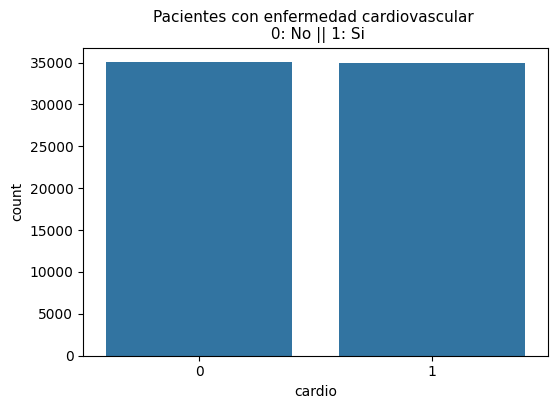

In [ ]:
# Exploración de las variables

# Cardio

print("Proporción de la columna cardio:")
print(df_Cardio['cardio'].value_counts(normalize=True),"\n")

# Plot distribution of target variable
plt.figure(figsize=(6, 4))
sns.countplot(x=df_Cardio['cardio'])
plt.title('Pacientes con enfermedad cardiovascular \n 0: No || 1: Si', fontsize=11)

plt.show()

In [ ]:
# Variables categóricas ordinales
var_cat = cols_ordinales

# Mostramos valor únicos de las columnas categóricas
for var in var_cat:
  print("----", var, "----")
  print(f"Los valores únicos de la columna ´{var} son {df_Cardio[var].unique()}")

---- cholesterol ----
Los valores únicos de la columna ´cholesterol son [1 3 2]
---- gluc ----
Los valores únicos de la columna ´gluc son [1 2 3]


In [ ]:
# Variables numéricas

# Mostramos los estadísticos básicos de las columnas numéricas
df_Cardio[cols_numericas].describe()

,age,height,weight,ap_hi,ap_lo
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,53.338686,164.359229,74.205690,128.817286,96.630414
std,6.765294,8.210126,14.395757,154.011419,188.472530
min,30.000000,55.000000,10.000000,-150.000000,-70.000000
25%,48.000000,159.000000,65.000000,120.000000,80.000000
50%,54.000000,165.000000,72.000000,120.000000,80.000000
75%,58.000000,170.000000,82.000000,140.000000,90.000000
max,65.000000,250.000000,200.000000,16020.000000,11000.000000


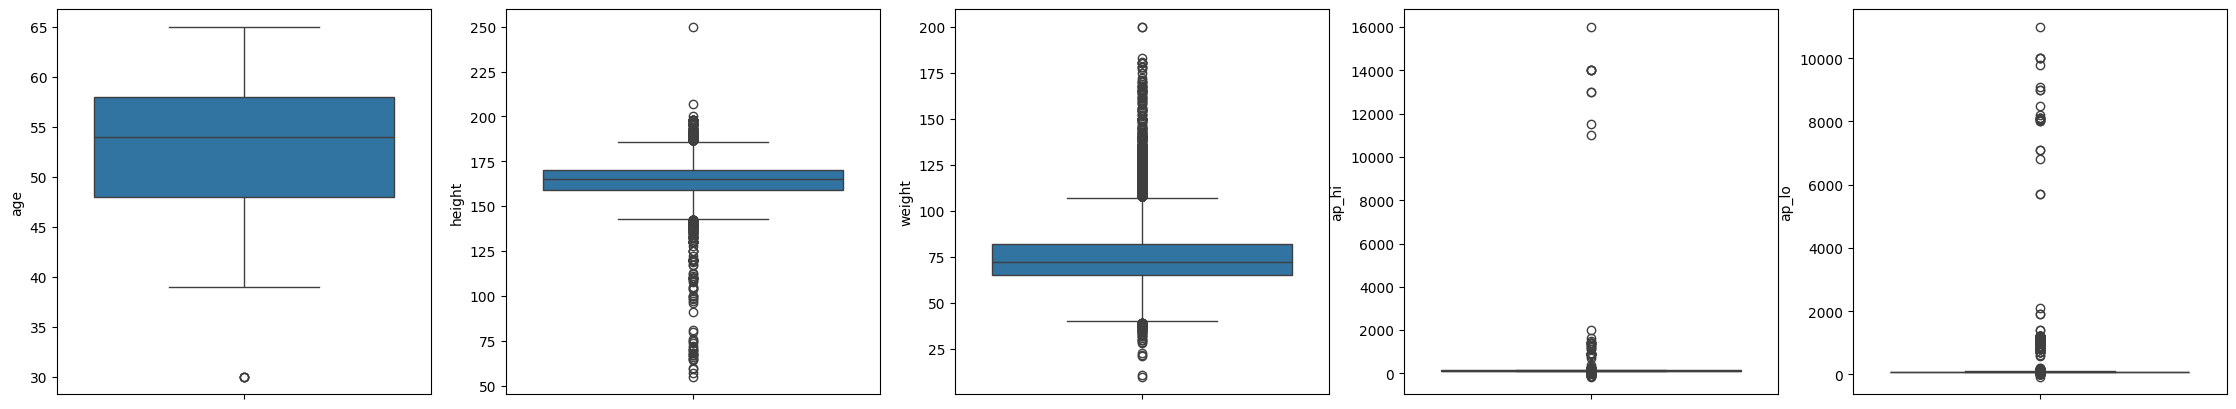

In [ ]:
# Parece que hay algunos outliers en las variables ap_hi y ap_lo
fig, axs = plt.subplots(1, 5, figsize=(28, 5))
for i, var_num in enumerate(cols_numericas):
  sns.boxplot(df_Cardio[var_num], ax=axs[i])

In [ ]:
# Corregimos los valores outliers

# Valores más altos de 500 o negativos no son posibles

# Sustituímos los outliers por NaNs
df_Cardio.loc[(df_Cardio['ap_hi'] > 500)| (df_Cardio['ap_hi'] < 0)] = np.nan
df_Cardio.loc[(df_Cardio['ap_lo'] > 500) | (df_Cardio['ap_lo'] < 0)] = np.nan

# Calculamos la mediana
media_ap_hi = df_Cardio['ap_hi'].median()
media_ap_lo = df_Cardio['ap_lo'].median()

# Sustituímos los NaNs por la mediana
df_Cardio['ap_hi'] = df_Cardio['ap_hi'].fillna(media_ap_hi)
df_Cardio['ap_lo'] = df_Cardio['ap_lo'].fillna(media_ap_lo)

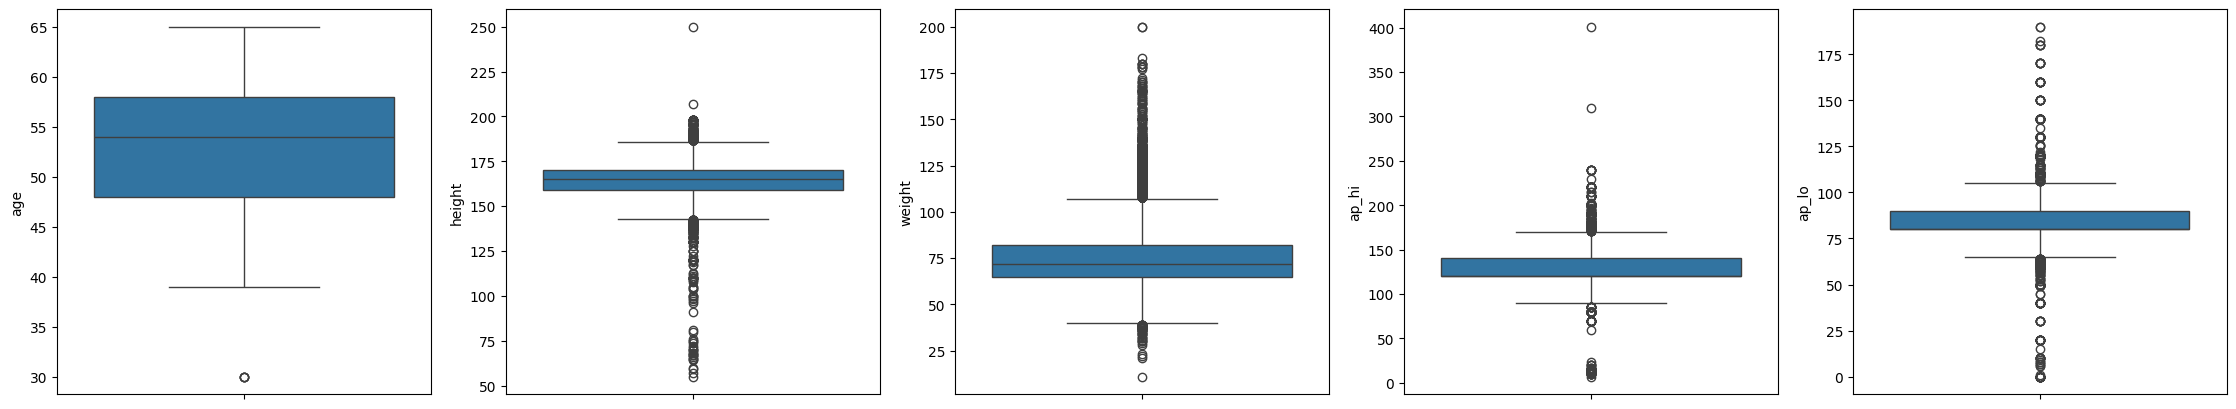

In [ ]:
# Volvemos a visualizar los boxplots
fig, axs = plt.subplots(1, 5, figsize=(28, 5))
for i, var_num in enumerate(cols_numericas):
  sns.boxplot(df_Cardio[var_num], ax=axs[i])

In [ ]:
# Comprobamos que las variables binarias solo tienen valores de 0 a 1
for cat in cols_binarias:
  print(f"Valores de la variable {cat}:", df_Cardio[cat].unique())

Valores de la variable gender: [ 1.  0. nan]
Valores de la variable smoke: [ 0.  1. nan]
Valores de la variable alco: [ 0.  1. nan]
Valores de la variable active: [ 1.  0. nan]


In [ ]:
# Hay valores nulos en el dataset!
# Si se mira con isna() no salen
df_Cardio.isnull().sum()

,0
age,999
gender,999
height,999
weight,999
ap_hi,0
ap_lo,0
cholesterol,999
gluc,999
smoke,999
alco,999


In [ ]:
# Como no tenemos la información de la variable cardio
# Tenemos que eliminar esas filas
df_Cardio.dropna(subset='cardio', inplace=True)

# Comprobamos que ya no hay valores nulos
df_Cardio.isnull().sum()

,0
age,0
gender,0
height,0
weight,0
ap_hi,0
ap_lo,0
cholesterol,0
gluc,0
smoke,0
alco,0



e) Antes de poder aplicar un modelo a estos datos, tenemos que aplicar una técnica de escalado. En este caso, estandariza los datos con la función `StandardScaler()` de la librería sklearn.



In [ ]:
# Cargamos la función StandardScaler
from sklearn.preprocessing import StandardScaler

cardio_preproc_df = df_Cardio.copy()

# Aplicamos el escalado a las variables
cols_num = cols_numericas+cols_ordinales+cols_binarias

# Creamos una instancia de StandardScaler
scaler = StandardScaler()

# Aplicamos el escalado estándar solo a las columnas numéricas
cardio_preproc_df[cols_num] = scaler.fit_transform(cardio_preproc_df[cols_num])

In [ ]:
# Comprobamos que la estandarización ha sido correcta
cardio_preproc_df[cols_num].describe()

,age,height,weight,ap_hi,ap_lo,cholesterol,gluc,gender,smoke,alco,active
count,6.900100e+04,6.900100e+04,6.900100e+04,6.900100e+04,6.900100e+04,6.900100e+04,6.900100e+04,6.900100e+04,6.900100e+04,6.900100e+04,6.900100e+04
mean,-5.126131e-16,-7.437936e-16,1.397792e-15,1.132733e-16,-2.967760e-16,9.782693e-17,-9.803288e-17,9.576742e-17,3.058379e-17,-5.231166e-17,4.654502e-17
std,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00
min,-3.446445e+00,-1.332987e+01,-4.405091e+00,-6.721855e+00,-8.234114e+00,-5.368771e-01,-3.950067e-01,-7.317122e-01,-3.103754e-01,-2.379671e-01,-2.020816e+00
25%,-7.868067e-01,-6.532936e-01,-6.363649e-01,-3.565220e-01,-1.349302e-01,-5.368771e-01,-3.950067e-01,-7.317122e-01,-3.103754e-01,-2.379671e-01,4.948497e-01
50%,9.973926e-02,7.804744e-02,-1.478263e-01,-3.565220e-01,-1.349302e-01,-5.368771e-01,-3.950067e-01,-7.317122e-01,-3.103754e-01,-2.379671e-01,4.948497e-01
75%,6.907699e-01,6.874983e-01,5.500860e-01,7.700855e-01,8.774679e-01,-5.368771e-01,-3.950067e-01,1.366658e+00,-3.103754e-01,-2.379671e-01,4.948497e-01
max,1.725074e+00,1.043871e+01,8.785451e+00,1.547231e+01,1.100145e+01,2.409989e+00,3.102473e+00,1.366658e+00,3.221905e+00,4.202262e+00,4.948497e-01


### Ejercicio 2

Las enfermedades cardiovasculares es la principal causa de muerte en todo el mundo, por este motivo, muchos estudios de clínicos se centran en caracterizar e detectar de manera más eficiente estas patologías.

En este ejercicio, vamos a crear un modelo de clasificación para ayudar a los doctores a identificar correctamente qué pacientes pueden tener problemas cardiovasculares.

a) Separa los datos en un conjunto de train y de test, con un porcentaje de 70%-30%. El conjunto de train se usará para entrenar los datos y el conjunto de test, para validar los resultados del modelo.

b) Aplica un modelo de [random forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) a los datos y muestra las métricas del modelo (accuracy, precision, recall, F2). Muestra también la matriz de confusión para ver como se distribuyen los resultados.

c) Para poder interpretar bien los datos, es necesario entender qué variables contribuyen más al modelo, es decir, qué variables son más importantes. Saca esta información del elemento `feature_importances_` del modelo de random forest.

**Nota**: Para más información podéis consultar este [enlance](https://forecastegy.com/posts/feature-importance-in-random-forests/).



In [ ]:
# a) Separar datos en train (70%) y test (30%)

# Creamos un modelo de clasificación para predecir
# si el paciente tiene o no una enfermedad cardiovascular

# Separamos los datos en X (características) e y (target)

X = cardio_preproc_df.drop(columns=target).values
y = cardio_preproc_df[target].values.reshape(-1,1)

# Separamos los datos en conjunto de train y test
# Usaremos un test size de 0.3
x_train, x_test, y_train, y_test=train_test_split(X,y, test_size=0.3,random_state=308)

In [ ]:
#b) Modelo de clasificación (Random Forest)

from sklearn.ensemble import RandomForestClassifier

# Usamos random forest
model = RandomForestClassifier()

# Aplicamos la LR a nuestro subset de entrenamiento
model.fit(x_train,y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier()

In [ ]:
# Revisamos la accuracy

# Accuracy en el subset de train
print("Accuracy train: ",metrics.accuracy_score(y_train,model.predict(x_train)))

# Accuracy en el subset de test
print("Accuracy test: ",metrics.accuracy_score(y_test,model.predict(x_test)))

# Accuracy en todo el conjunto
print("Accuray", metrics.accuracy_score(y,model.predict(X)))

# Informe general
print(metrics.classification_report(y,model.predict(X)))

# La accuracy es bastante buena, y las otras métricas también
# Sin embargo, hay un poco de overfitting

Accuracy train:  0.9786749482401657
Accuracy test:  0.7081300420269552
Accuray 0.8975087317575108
              precision    recall  f1-score   support

         0.0       0.89      0.91      0.90     34854
         1.0       0.90      0.89      0.90     34147

    accuracy                           0.90     69001
   macro avg       0.90      0.90      0.90     69001
weighted avg       0.90      0.90      0.90     69001



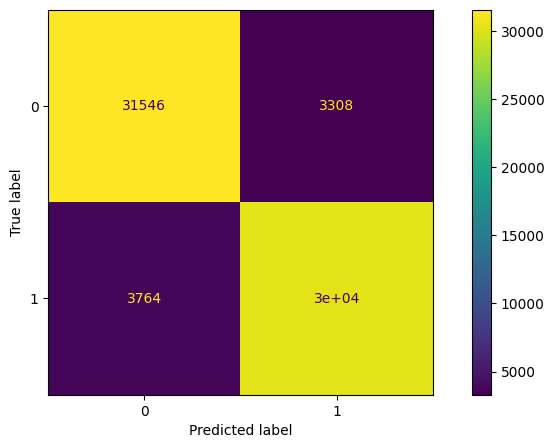

In [ ]:
# Calculamos la matriz de confusión
cm = metrics.confusion_matrix(y,model.predict(X))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
fig , ax = plt.subplots(figsize=(10,5))
cm_display.plot(ax=ax)
plt.show()

Text(0.5, 1.0, 'Importancia de las variables del modelo')

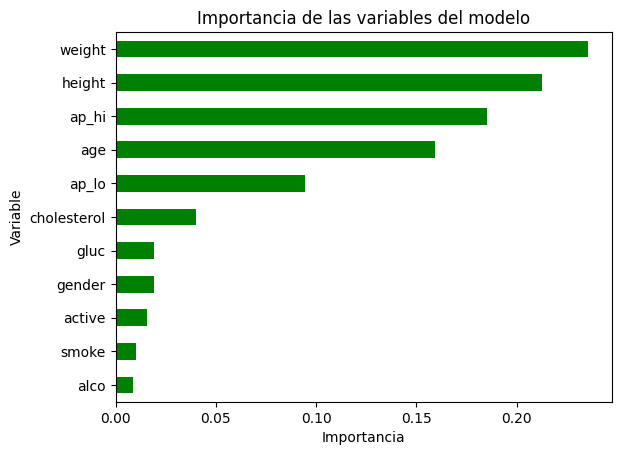

In [ ]:
cols_modelo = df_Cardio.drop(columns=target).columns
global_importances = pd.Series(model.feature_importances_, index=cols_modelo)
global_importances.sort_values(ascending=True, inplace=True)
global_importances.plot.barh(color='green')
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.title("Importancia de las variables del modelo")

### Ejercicio 3

Ahora vamos a intentar identificar patrones distintos entre los pacientes con enfermedades cardiovasculares. Para lograrlo, usaremos algoritmos no supervisados.

a) Crea un nuevo dataset con solo los datos de los pacientes. A continuación, aplica un algoritmo K-Means a los datos. Para seleccionar el número de clusters óptimo, usa el método de Elbow para identificar el punto óptimo de separación. ¿Qué número de clusters os parece mejor? Crea una nueva columna con la información del cluster, es decir, para cada muestra indicará a qué cluster pertenece.

**Nota**: Podéis encontrar un ejemplo del método de Elbow en los ejercicios del dataset de pingüinos de las Unidades 7-8 de Análisis exploratorio de datos.



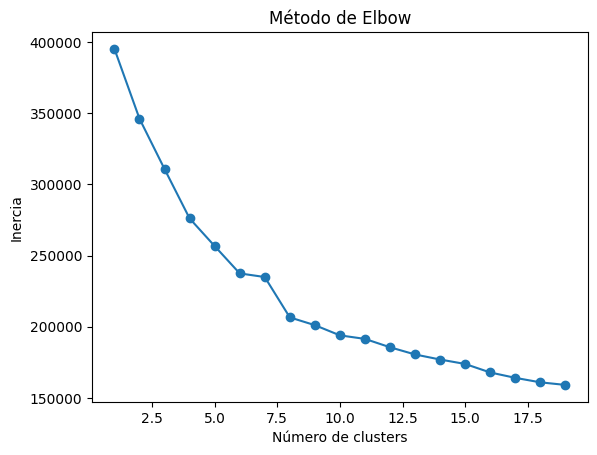

In [ ]:
# a) Clustering KMeans

# Importamos la librería KMeans
from sklearn.cluster import KMeans

# Queremos identificar subgrupos en los pacientes
# Vamos a quedarnos solo con los pacientes en el df
cardio_patients_df = cardio_preproc_df[cardio_preproc_df['cardio'] == 1]


# Vamos a evaluar de 1 a 20 grupos
# Y para cada iteracion vamos a calcular la inercia
inertia = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto").fit(cardio_patients_df.drop(columns=target))
    inertia.append(kmeans.inertia_)

# Hacemos el gráfico de la inercia vs el número de clusters
plt.plot(range(1, 20), inertia, marker="o")

# Añadimos la información de los ejes
plt.xlabel("Número de clusters")
plt.ylabel("Inercia")
plt.title("Método de Elbow")
plt.show()

In [ ]:
# Vamos a usar 5 grupos en el KMeans, pero entre 6-8 también sería una buena opción
kmeans = KMeans(n_clusters=5, random_state=42).fit(cardio_patients_df.drop(columns=target))

# Vamos a guardar la información del clustering en el dataset original
cardio_patients_df['Clustering_KMeans'] = kmeans.labels_

<ipython-input-30-17d881a7f032>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cardio_patients_df['Clustering_KMeans'] = kmeans.labels_


In [ ]:
# Vamos a usar las variables sin estandarizar
# Para tener valores mas interpretables
cardio_init_patients_df = df_Cardio[df_Cardio['cardio'] == 1]

cardio_init_patients_df['Clustering_KMeans'] = kmeans.labels_

<ipython-input-31-38b22371ed09>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cardio_init_patients_df['Clustering_KMeans'] = kmeans.labels_
